## Heart disease Pridiction using machine learning
This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether or not someone has heart disease based on their medical attributes.

We're going to take the following approach:

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

### 1. Problem Definition
In a statement,

Given clinical parameters about a patient, can we predict whether or not they have heart disease?

### 2. Data
The original data came from the Cleavland data from the UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/heart+Disease

There is also a version of it available on Kaggle. https://www.kaggle.com/ronitf/heart-disease-uci

### 3. Evaluation
If we can reach 95% accuracy at predicting whether or not a patient has heart disease during the proof of concept, we'll pursue the project.

### 4. Features
This is where you'll get different information about each of the features in your data. You can do this via doing your own research (such as looking at the links above) or by talking to a subject matter expert (someone who knows about the dataset).

* age
* sex (1 = male; 0 = female)s
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [1]:

# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# we want our plots to appear inside the notebook
%matplotlib inline 

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [2]:
df = pd.read_csv("heart.csv")
df.shape # (rows, columns)

(303, 14)

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [5]:
# find out how many of each class there
df["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

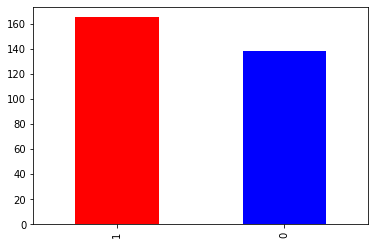

In [6]:
df["target"].value_counts().plot(kind="bar",
                                 color=["Red", "Blue"]);

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [8]:
# Are there any missing values?
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [9]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Heart Disease Frequency according to Sex

In [10]:
# Compare target column with sex column  
#(1 = male; 0 = female)
# Target - have disease or not (1=yes, 0=no
pd.crosstab(df.target, df.sex)

sex,0,1
target,,
0,24,114
1,72,93


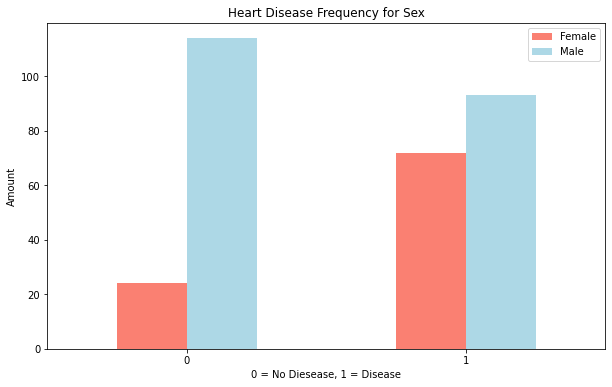

In [11]:

# Create a plot of crosstab
pd.crosstab(df.target, df.sex).plot(kind="bar",
                                    figsize=(10, 6),
                                    color=["salmon", "lightblue"])

plt.title("Heart Disease Frequency for Sex")
plt.xlabel("0 = No Diesease, 1 = Disease")
plt.ylabel("Amount")
plt.legend(["Female", "Male"]);
plt.xticks(rotation=0);

### Age VS MAX Heart Rate for Heart DIsease
thalach - maximum heart rate achieved

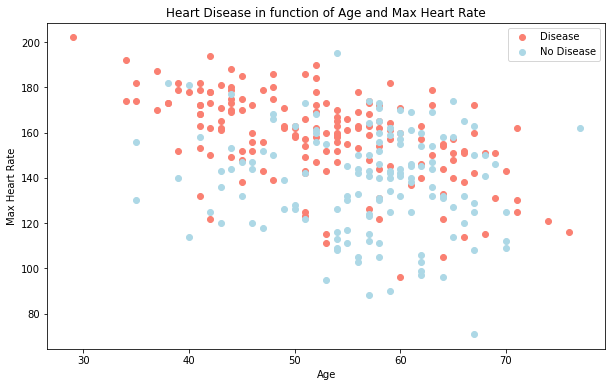

In [12]:
# Create another figure
plt.figure(figsize=(10, 6))

# Scatter with postivie examples
plt.scatter(df.age[df.target==1],
            df.thalach[df.target==1],
            c="salmon")

# Scatter with negative examples
plt.scatter(df.age[df.target==0],
            df.thalach[df.target==0],
            c="lightblue")

# Add some helpful info
plt.title("Heart Disease in function of Age and Max Heart Rate")
plt.xlabel("Age")
plt.ylabel("Max Heart Rate")
plt.legend(["Disease", "No Disease"]);

(14.5, -0.5)

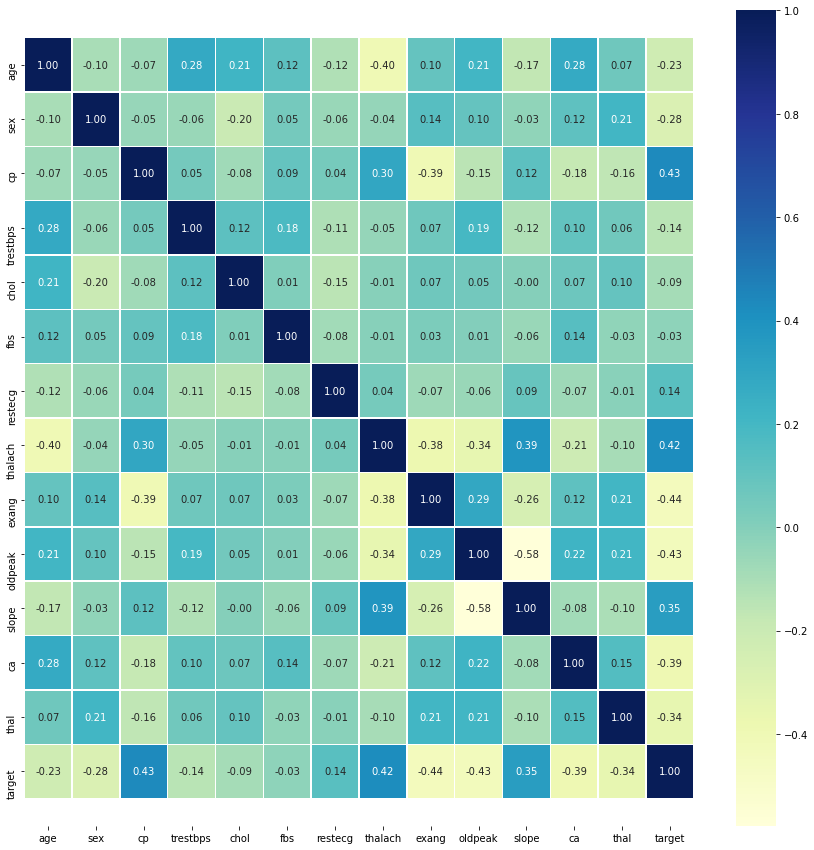

In [13]:
# Let's make our correlation matrix a little prettier
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

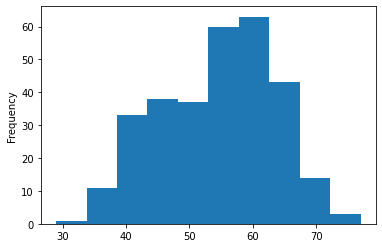

In [14]:
# Check the distribution of the age column with a histogram
df.age.plot.hist();

### Heart Disease Frequency per Chest Pain Type
cp - chest pain type
* 0: Typical angina: chest pain related decrease blood supply to the heart
* 1: Atypical angina: chest pain not related to heart
* 2: Non-anginal pain: typically esophageal spasms (non heart related)
* 3: Asymptomatic: chest pain not showing signs of disease

In [15]:
pd.crosstab(df.cp, df.target)

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


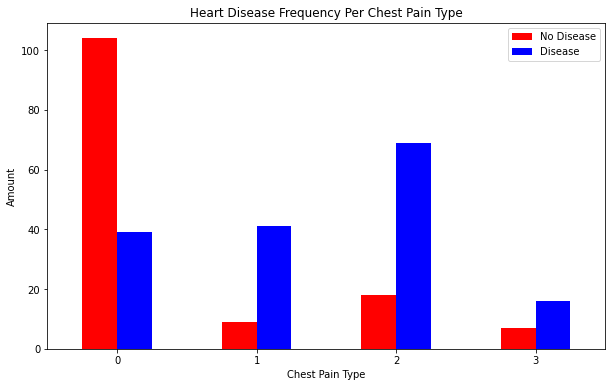

In [16]:
# Make the crosstab more visual
pd.crosstab(df.cp, df.target).plot(kind="bar",
                                   figsize=(10, 6),
                                   color=["Red", "Blue"])

# Add some communication
plt.title("Heart Disease Frequency Per Chest Pain Type")
plt.xlabel("Chest Pain Type")
plt.ylabel("Amount")
plt.legend(["No Disease", "Disease"])
plt.xticks(rotation=0);

In [17]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


A correlation matrix is simply a table which displays the correlation. The measure is best used in variables that demonstrate a linear relationship between each other. The fit of the data can be visually represented in a scatterplot.

In [18]:

df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


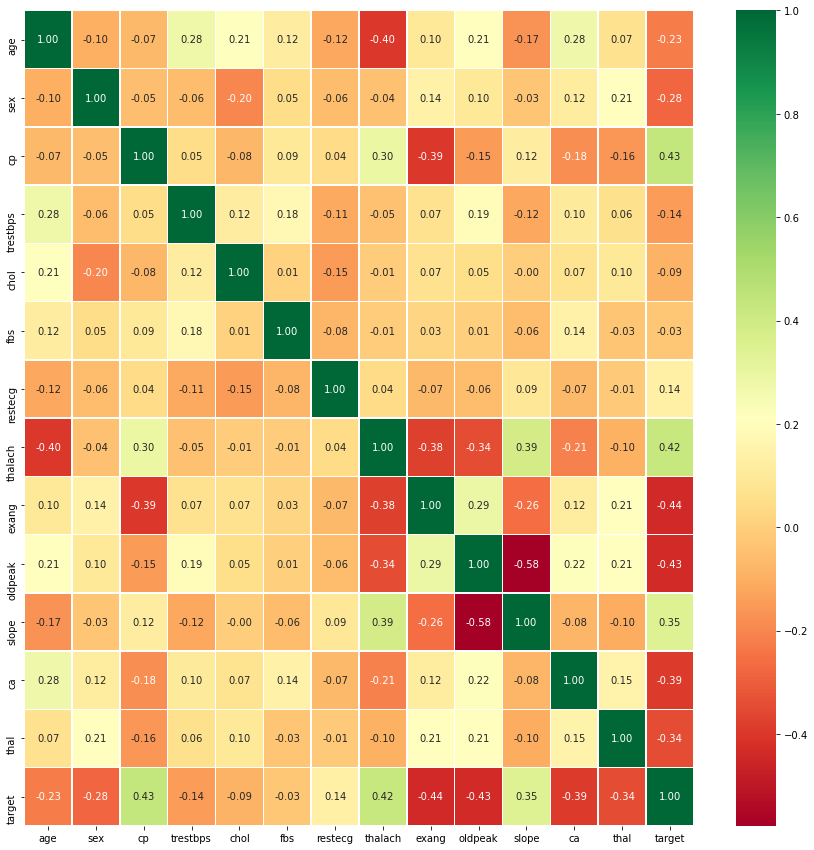

In [19]:
# Let's make our correlation matrix a little prettier
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="RdYlGn");

#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)

# Modeling

In [20]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [21]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [22]:
# Split data into X and y
X = df.drop("target", axis=1)

y = df["target"]

In [23]:
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [24]:
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 303, dtype: int64

In [25]:
# Split data into train and test sets
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

In [26]:
y_train, len(y_train)

(132    1
 202    0
 196    0
 75     1
 176    0
       ..
 188    0
 71     1
 106    1
 270    0
 102    1
 Name: target, Length: 242, dtype: int64,
 242)

Now we've got our data split into training and test sets, it's time to build a machine learning model.

We'll train it (find the patterns) on the training set.

And we'll test it (use the patterns) on the test set.

We're going to try 3 different machine learning models:

1. Logistic Regression
2. K-Nearest Neighbours Classifier
3. Random Forest Classifier
4. Support Vector Machine
5. Decision Tree Classifier
6. XGBoost Clssifier

In [27]:
# Put models in a dictionary

models  ={"Logistic Regression": LogisticRegression(),
         "KNN" : KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "Support Vector Machine": SVC(),
         "Decision Tree Classifier": DecisionTreeClassifier(),
         "XGBoost Clssifier": XGBClassifier()}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [28]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test);

model_scores

C:\Users\HP\Desktop\ML_Course\heart_disease_project\env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\Desktop\ML_Course\heart_disease_project\env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_d

[22:02:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8360655737704918,
 'Support Vector Machine': 0.7049180327868853,
 'Decision Tree Classifier': 0.8360655737704918,
 'XGBoost Clssifier': 0.819672131147541}

### Model Comparison


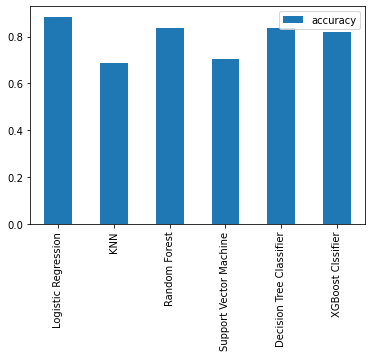

In [29]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

Now we've got a baseline model... and we know a model's first predictions aren't always what we should based our next steps off. What should we do?

Let's look at the following:

* Hypyterparameter tuning
* Feature importance
* Confusion matrix
* Cross-validation
* Precision
* Recall
* F1 score
* Classification report
* ROC curve
* Area under the curve (AUC)

### Hyperparameter tuning (by hand)

In [30]:
# Let's tune KNN

train_scores = []
test_scores = []

# Create a list of differnt values for n_neighbors
neighbors = range(1, 21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors=i)
    
    # Fit the algorithm
    knn.fit(X_train, y_train)
    
    # Update the training scores list
    train_scores.append(knn.score(X_train, y_train))
    
    # Update the test scores list
    test_scores.append(knn.score(X_test, y_test))

In [31]:
train_scores

[1.0,
 0.8099173553719008,
 0.7727272727272727,
 0.743801652892562,
 0.7603305785123967,
 0.7520661157024794,
 0.743801652892562,
 0.7231404958677686,
 0.71900826446281,
 0.6942148760330579,
 0.7272727272727273,
 0.6983471074380165,
 0.6900826446280992,
 0.6942148760330579,
 0.6859504132231405,
 0.6735537190082644,
 0.6859504132231405,
 0.6652892561983471,
 0.6818181818181818,
 0.6694214876033058]

In [32]:
test_scores

[0.6229508196721312,
 0.639344262295082,
 0.6557377049180327,
 0.6721311475409836,
 0.6885245901639344,
 0.7213114754098361,
 0.7049180327868853,
 0.6885245901639344,
 0.6885245901639344,
 0.7049180327868853,
 0.7540983606557377,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869,
 0.6885245901639344,
 0.7213114754098361,
 0.6885245901639344,
 0.6885245901639344,
 0.7049180327868853,
 0.6557377049180327]

Maximum KNN score on the test data: 75.41%


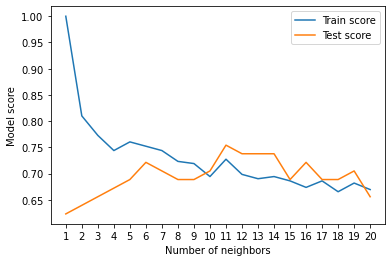

In [33]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

## Lets Tuning Support Vector Machine with GrdiSearchCV


last


## Hyperparameter tuning with RandomizedSearchCV
We're going to tune:

* LogisticRegression()
* RandomForestClassifier()


... using RandomizedSearchCV

### Create a hyperparameter grid for LogisticRegression

In [34]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}


Now we've got hyperparameter grids setup for each of our models, let's tune them using RandomizedSearchCV...

In [35]:
# Tune LogisticRegression

np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [36]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.23357214690901212}

In [37]:
rs_log_reg.score(X_test, y_test)

0.8852459016393442

Now we've tuned LogisticRegression(), let's do the same for RandomForestClassifier()...

### Create a hyperparameter grid for RandomForestClassifier

In [38]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(), 
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [39]:
# Find the best hyperparameters
rs_rf.best_params_

{'n_estimators': 210,
 'min_samples_split': 4,
 'min_samples_leaf': 19,
 'max_depth': 3}

In [40]:
# Evaluate the randomized search RandomForestClassifier model
rs_rf.score(X_test, y_test)

0.8688524590163934

## Hyperparamter Tuning with GridSearchCV¶

Since our LogisticRegression model provides the best scores so far, we'll try and improve them again using GridSearchCV...

In [41]:
# Different hyperparameters for our LogisticRegression model
log_reg_grid = {"C": np.logspace(-4, 4, 30),
                "solver": ["liblinear"]}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
gs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [42]:
# Check the best hyperparmaters
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [43]:
# Evaluate the grid search LogisticRegression model
gs_log_reg.score(X_test, y_test)

0.8852459016393442

## Evaluting our tuned machine learning classifier, beyond accuracy
* ROC curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1-score

... and it would be great if cross-validation was used where possible.

To make comparisons and evaluate our trained model, first we need to make predictions.

In [44]:
# Make predictions with tuned model
y_preds = gs_log_reg.predict(X_test)

In [45]:

y_preds

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [46]:
y_test

179    0
228    0
111    1
246    0
60     1
      ..
249    0
104    1
300    0
193    0
184    0
Name: target, Length: 61, dtype: int64

In [47]:
X_test

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
179,57,1,0,150,276,0,0,112,1,0.6,1,1,1
228,59,1,3,170,288,0,0,159,0,0.2,1,0,3
111,57,1,2,150,126,1,1,173,0,0.2,2,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
60,71,0,2,110,265,1,0,130,0,0.0,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,69,1,2,140,254,0,0,146,0,2.0,1,3,3
104,50,1,2,129,196,0,1,163,0,0.0,2,0,2
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
193,60,1,0,145,282,0,0,142,1,2.8,1,2,3


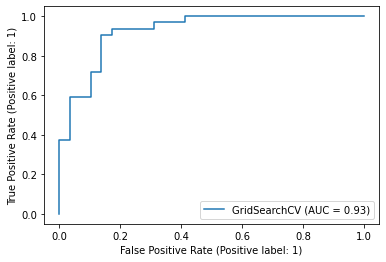

In [48]:
# Plot ROC curve and calculate and calculate AUC metric
plot_roc_curve(gs_log_reg, X_test, y_test)

In [49]:
# Confusion matrix
print(confusion_matrix(y_test, y_preds))

[[25  4]
 [ 3 29]]


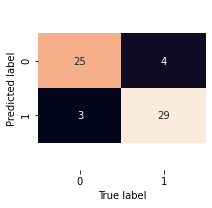

In [50]:

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_conf_mat(y_test, y_preds)

In [51]:

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



## Calculate evaluation metrics using cross-validation
We're going to calculate accuracy, precision, recall and f1-score of our model using cross-validation and to do so we'll be using cross_val_score().

In [52]:
#Check best hyperparameters
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [53]:
# Create a new classifier with best parameters
clf = LogisticRegression(C=0.20433597178569418,
                         solver="liblinear")

In [54]:
# Cross-validated accuracy
cv_acc = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="accuracy")
cv_acc

array([0.81967213, 0.90163934, 0.8852459 , 0.88333333, 0.75      ])

In [55]:
cv_acc = np.mean(cv_acc)
cv_acc

0.8479781420765027

In [56]:
# Cross-validated precision
cv_precision = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="precision")
cv_precision=np.mean(cv_precision)
cv_precision

0.8215873015873015

In [57]:
# Cross-validated recall
cv_recall = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="recall")
cv_recall = np.mean(cv_recall)
cv_recall

0.9272727272727274

In [58]:

# Cross-validated f1-score
cv_f1 = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="f1")
cv_f1 = np.mean(cv_f1)
cv_f1

0.8705403543192143

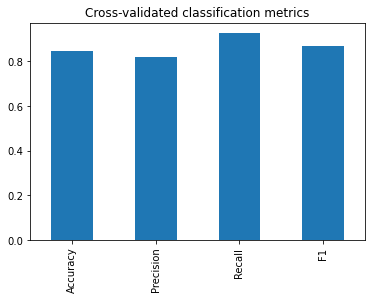

In [59]:
# Visualize cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                           "Precision": cv_precision,
                           "Recall": cv_recall,
                           "F1": cv_f1},
                          index=[0])

cv_metrics.T.plot.bar(title="Cross-validated classification metrics",
                      legend=False);

## Feature Importance
Feature importance is another as asking, "which features contributed most to the outcomes of the model and how did they contribute?"

Finding feature importance is different for each machine learning model. One way to find feature importance is to search for "(MODEL NAME) feature importance".

Let's find the feature importance for our LogisticRegression model...

In [60]:
# Fit an instance of LogisticRegression
clf = LogisticRegression(C=0.20433597178569418,
                         solver="liblinear")

clf.fit(X_train, y_train);

In [61]:
# Check coef_
clf.coef_

array([[ 0.00316728, -0.86044612,  0.66067059, -0.01156993, -0.00166374,
         0.0438612 ,  0.31275814,  0.02459361, -0.60413056, -0.5686283 ,
         0.45051621, -0.63609878, -0.67663373]])

In [62]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
svm_clf = SVC(kernel='rbf', gamma=0.1, C=1.0)

params = {"C":(0.1, 0.5, 1, 2, 5, 10, 20), 
          "gamma":(0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1), 
          "kernel":('linear', 'poly', 'rbf')}

svm_cv = GridSearchCV(svm_clf, params,
                      n_jobs=-1, 
                      cv=5, 
                      verbose=1, 
                      scoring="accuracy")

svm_cv.fit(X_train, y_train)
best_params = svm_cv.best_params_
print(f"Best params: {best_params}")
svm_clf = SVC(**best_params)
svm_clf.fit(X_train, y_train)

Fitting 5 folds for each of 147 candidates, totalling 735 fits


In [ ]:
# Evaluate the randomized search RandomForestClassifier model
svm_clf.score(X_test, y_test)